В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------

### Imports

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import roc_auc_score, confusion_matrix, root_mean_squared_error


### **Завдання 0**.
Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

In [2]:
os.listdir('./data')

['bank-customer-churn-prediction',
 'cars.csv',
 'credit',
 'customer_segmentation_train.csv',
 'estimation_of_obesity_levels_based_on_eating_habits_and_physical.csv',
 'medical-charges.csv',
 'regression_data.csv']

In [3]:
os.listdir('./data/bank-customer-churn-prediction/')

['churn_predict_model_pipeline.joblib',
 'first_prediction.JPG',
 'first_prediction_2.JPG',
 'log_reg.joblib',
 'sample_submission.csv',
 'submission_log_reg.csv',
 'submission_log_reg_num_poly_4.csv',
 'test.csv',
 'train.csv',
 'train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

In [4]:
data_dir = './data/bank-customer-churn-prediction/'

### **Завдання 1**.
**Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекомендую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + виведення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попередньому ДЗ! Тож, тут просто задача все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

Area under ROC score on Train dataset: 0.88


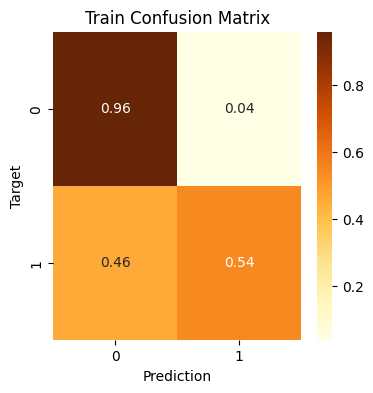

Area under ROC score on Validation dataset: 0.87


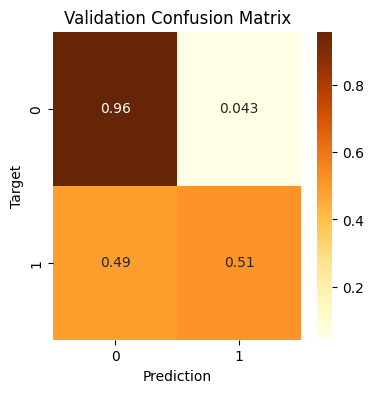

['./data/bank-customer-churn-prediction/churn_predict_model_pipeline.joblib']

In [ ]:
# 1. Read the data from file
raw_df = pd.read_csv(data_dir + 'train.csv', index_col=0)

# Split on train and validation sets (20% for validation set)
train_df, val_df = train_test_split(raw_df,
                                    test_size=0.2,
                                    random_state=24,
                                    stratify=raw_df['Exited'])

# Create inputs and targets
input_cols = list(train_df.columns)[2:-1]
target_col = 'Exited'

train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes('number').columns.to_list()
categorical_cols = train_inputs.select_dtypes('object').columns.to_list()
gender_col = ['Gender']
geography_col = ['Geography']

# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

gender_transformer = Pipeline(steps=[
    ('gender_onehot_enc', OneHotEncoder(drop='first',
                                        sparse_output=False,
                                        handle_unknown='ignore'))
])

geography_transformer = Pipeline(steps=[
    ('geography_onehot_enc', OneHotEncoder(sparse_output=False,
                                           handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('gender', gender_transformer, gender_col),
        ('geography', geography_transformer, geography_col)
])
preprocessor.set_output(transform='pandas')

# Create a pipeline that includes preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model_pipeline.fit(train_inputs, train_targets)


# Helper function to predict, compute metrics and plot confusion matrix
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds_proba = model_pipeline.predict_proba(inputs)[:, 1]
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, preds_proba)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")

    cm = confusion_matrix(targets, preds, normalize='true')
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, cmap='YlOrBr')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    return preds_proba, preds


# Evaluate on train and validation sets
train_preds_proba, train_preds = predict_and_plot(model_pipeline,
                                                  train_inputs,
                                                  train_targets,
                                                  'Train')
val_preds_proba, val_preds = predict_and_plot(model_pipeline,
                                              val_inputs,
                                              val_targets,
                                              'Validation')

# Save the trained model
joblib.dump(model_pipeline, data_dir + 'churn_predict_model_pipeline.joblib')

### **Завдання 2**.
Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.92


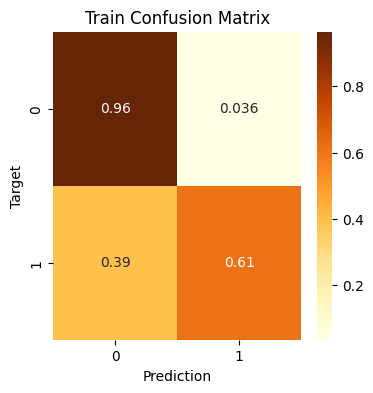

Area under ROC score on Validation dataset: 0.91


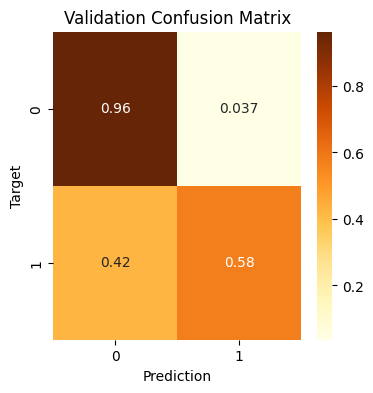

In [ ]:
numeric_poly_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2))
])

preprocessor_num_poly_2 = ColumnTransformer(
    transformers=[
        ('num_poly', numeric_poly_transformer, numeric_cols),
        ('gender', gender_transformer, gender_col),
        ('geography', geography_transformer, geography_col)
])
preprocessor_num_poly_2.set_output(transform='pandas')

model_num_poly_2_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_num_poly_2),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_num_poly_2_pipeline.fit(train_inputs, train_targets)

train_preds_proba_num_poly_2, train_preds_num_poly_2 = predict_and_plot(
    model_num_poly_2_pipeline, train_inputs, train_targets, 'Train')

val_preds_proba_num_poly_2, val_preds_num_poly_2 = predict_and_plot(
    model_num_poly_2_pipeline, val_inputs, val_targets, 'Validation')

Area under ROC score on Train dataset: 0.92


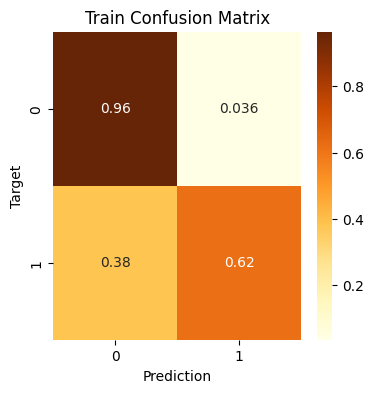

Area under ROC score on Validation dataset: 0.91


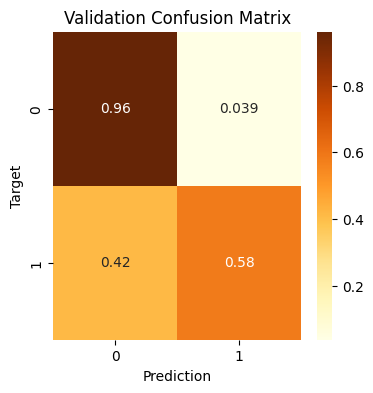

In [ ]:
# Add polynomial features for all features after preprocessor
model_poly_2_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=2)),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_poly_2_pipeline.fit(train_inputs, train_targets)

train_preds_proba_poly_2, train_preds_poly_2 = predict_and_plot(model_poly_2_pipeline,
                                                                train_inputs,
                                                                train_targets,
                                                                'Train')

val_preds_proba_poly_2, val_preds_poly_2 = predict_and_plot(model_poly_2_pipeline,
                                                            val_inputs,
                                                            val_targets,
                                                            'Validation')

In [8]:
len(model_poly_2_pipeline[-2].get_feature_names_out())

91

This model performs better than the simple logistic regression. While it gives a lower AUROC value, the true positive prediction increases from 51-54% to 65-68%.

However, this model shows a tendency to overfit, as its performance on the training set is better than on the validation set.

### **Завдання 3**. 
Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається результат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Number of features: 499
Area under ROC score on Train dataset: 0.93


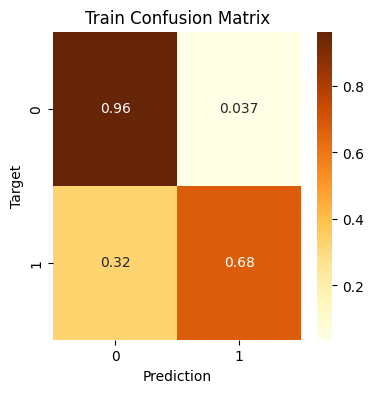

Area under ROC score on Validation dataset: 0.92


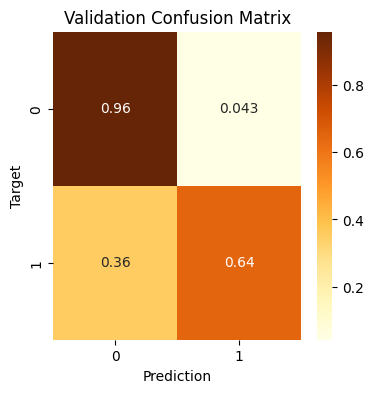

In [9]:
numeric_poly_4_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=4))
])

preprocessor_num_poly_4 = ColumnTransformer(
    transformers=[
        ('num_poly_4', numeric_poly_4_transformer, numeric_cols),
        ('gender', gender_transformer, gender_col),
        ('geography', geography_transformer, geography_col)
])

preprocessor_num_poly_4.set_output(transform='pandas')

model_num_poly_4_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_num_poly_4),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_num_poly_4_pipeline.fit(train_inputs, train_targets)

num_feats = len(model_num_poly_4_pipeline[-2].get_feature_names_out())
print(f"Number of features: {num_feats}")

train_preds_proba_num_poly_4, train_preds_num_poly_4 = predict_and_plot(model_num_poly_4_pipeline,
                                                                        train_inputs, train_targets,
                                                                        'Train')
val_preds_proba_num_poly_4, val_preds_num_poly_4 = predict_and_plot(model_num_poly_4_pipeline,
                                                                    val_inputs, val_targets,
                                                                    'Validation')

Number of features: 1820
Area under ROC score on Train dataset: 0.94


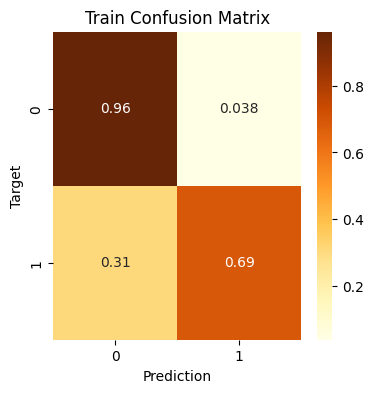

Area under ROC score on Validation dataset: 0.92


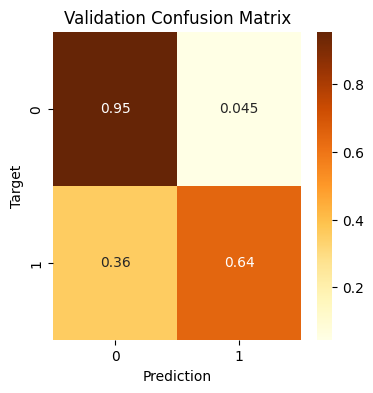

In [ ]:
# Add polynomial features for all features after preprocessor
model_poly_4_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=4)),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_poly_4_pipeline.fit(train_inputs, train_targets)

num_feats = len(model_poly_4_pipeline[-2].get_feature_names_out())
print(f"Number of features: {num_feats}")

train_preds_proba_poly_4, train_preds_poly_4 = predict_and_plot(model_poly_4_pipeline,
                                                                train_inputs, train_targets,
                                                                'Train')
val_preds_proba_poly_4, val_preds_poly_4 = predict_and_plot(model_poly_4_pipeline,
                                                            val_inputs, val_targets,
                                                            'Validation')

This models show very similar result to model with degree = 2 of polynomial features.

Let's make submission to Kaggle with prediction from `model_num_poly_4_pipeline`.

In [11]:
test_df = pd.read_csv(data_dir + 'test.csv')
submission = pd.read_csv(data_dir + 'sample_submission.csv')

test_inputs = test_df[input_cols]
test_preds_proba = model_num_poly_4_pipeline.predict_proba(test_inputs)[:, 1]

submission['Exited'] = test_preds_proba

submission[:5]

,id,Exited
0,15000,0.093960
1,15001,0.016899
2,15002,0.067358
3,15003,0.423233
4,15004,0.021933


In [12]:
submission.to_csv(data_dir + 'submission_log_reg_num_poly_4.csv', index=False)

### **Завдання 4. Перенавчання і регуляризація**.

  Завантажте набір даних `regression_data.csv` та розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [13]:
regression_data = pd.read_csv('./data/regression_data.csv')
regression_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [14]:
train, test = train_test_split(regression_data, test_size=0.2, random_state=24)

print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")

train.shape: (103, 6)
test.shape: (26, 6)


In [15]:
train_inputs, train_targets = train.drop('target', axis=1), train['target']
test_inputs, test_targets = test.drop('target', axis=1), test['target']

In [16]:
np.mean(train['target']), np.std(train['target'])

(np.float64(-4.963446938092935), np.float64(44.98671233931295))

In [17]:
def train_and_evaluate_model(scaler, degree, regressor,
                             train_inputs, train_targets,
                             test_inputs, test_targets):
    model = Pipeline(steps=[
        ('scaler', scaler),
        ('poly', PolynomialFeatures(degree)),
        ('regressor', regressor)
    ])

    model.fit(train_inputs, train_targets)

    num_feats_after = len(model[-2].get_feature_names_out())
    print(f"Original dataset shape: {train_inputs.shape}")
    print(f"Dataset with polynomial features contains {num_feats_after} features")

    train_pred = model.predict(train_inputs)
    test_pred = model.predict(test_inputs)

    train_rmse = np.round(root_mean_squared_error(train_targets, train_pred), 4)
    test_rmse = np.round(root_mean_squared_error(test_targets, test_pred), 4)

    eval_result = dict(model_name=str(model[-1]),
                       scaler=str(scaler),
                       polynomial_degree=degree,
                       rmse_on_train=train_rmse,
                       rmse_on_test=test_rmse)

    display(pd.DataFrame([eval_result]).T)

    plt.figure(figsize=(5, 4))
    plt.scatter(train_targets, train_pred, c='tan', label='train')
    plt.scatter(test_targets, test_pred, c='chocolate', label='test')
    plt.axline((0, 0), slope=1, linestyle='--', color='g')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.show()


Original dataset shape: (103, 5)
Dataset with polynomial features contains 252 features


,0
model_name,LinearRegression()
scaler,MinMaxScaler()
polynomial_degree,5
rmse_on_train,0.0
rmse_on_test,53.2844


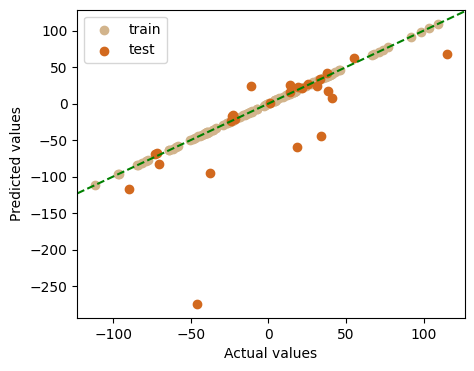

In [18]:
scaler = MinMaxScaler()
degree = 5
regressor = LinearRegression()

train_and_evaluate_model(scaler, degree, regressor,
                         train_inputs, train_targets,
                         test_inputs, test_targets)


This model performs poorly, as its achieves perfect results on the training set but performs poorly on the validation set.

After applying `PolynomialFeatures` with `degree = 5`, the dataset contains 252 features but only 103 observation. This imbalance allows the model to memorize the data but prevents it from generalizing patterns, leading to overfitting.

The linear regression model without any preprocessing perform enough well.

### **Завдання 5**.
Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

Original dataset shape: (103, 5)
Dataset with polynomial features contains 53130 features


,0
model_name,LinearRegression()
scaler,MinMaxScaler()
polynomial_degree,20
rmse_on_train,0.0
rmse_on_test,416.3088


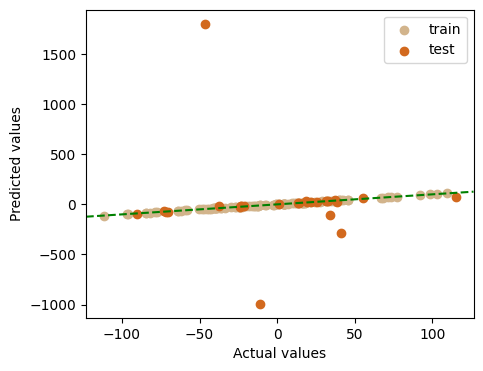

Original dataset shape: (103, 5)
Dataset with polynomial features contains 53130 features


,0
model_name,Ridge(random_state=24)
scaler,MinMaxScaler()
polynomial_degree,20
rmse_on_train,5.4079
rmse_on_test,41.804


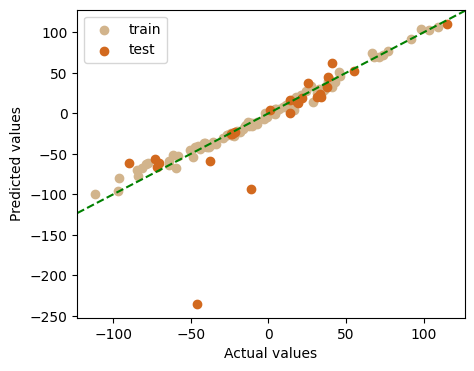

Original dataset shape: (103, 5)
Dataset with polynomial features contains 53130 features


,0
model_name,"Ridge(alpha=0.5, random_state=24)"
scaler,MinMaxScaler()
polynomial_degree,20
rmse_on_train,3.8367
rmse_on_test,159.8022


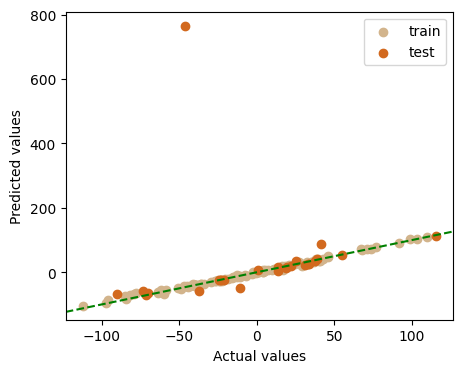

Original dataset shape: (103, 5)
Dataset with polynomial features contains 53130 features


,0
model_name,"Ridge(alpha=2, random_state=24)"
scaler,MinMaxScaler()
polynomial_degree,20
rmse_on_train,7.3847
rmse_on_test,174.7437


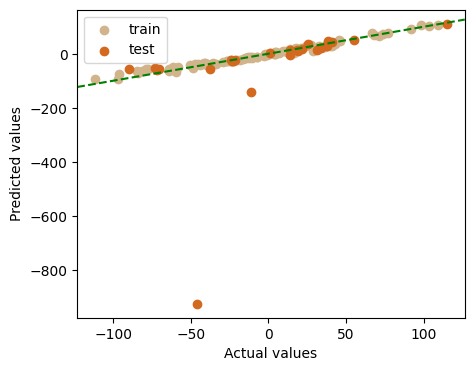

Original dataset shape: (103, 5)
Dataset with polynomial features contains 53130 features


,0
model_name,Lasso(random_state=24)
scaler,MinMaxScaler()
polynomial_degree,20
rmse_on_train,4.9972
rmse_on_test,5.1788


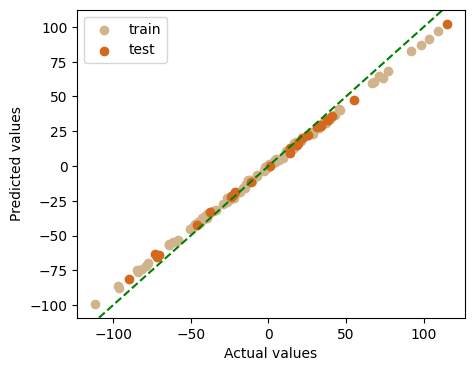

Original dataset shape: (103, 5)
Dataset with polynomial features contains 53130 features


,0
model_name,"Lasso(alpha=0.5, random_state=24)"
scaler,MinMaxScaler()
polynomial_degree,20
rmse_on_train,2.6601
rmse_on_test,2.7463


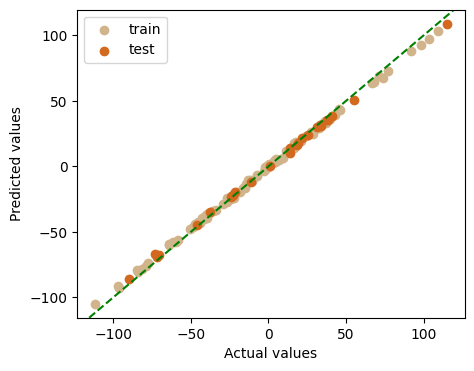

Original dataset shape: (103, 5)
Dataset with polynomial features contains 53130 features


,0
model_name,"Lasso(alpha=2, random_state=24)"
scaler,MinMaxScaler()
polynomial_degree,20
rmse_on_train,9.8262
rmse_on_test,10.1794


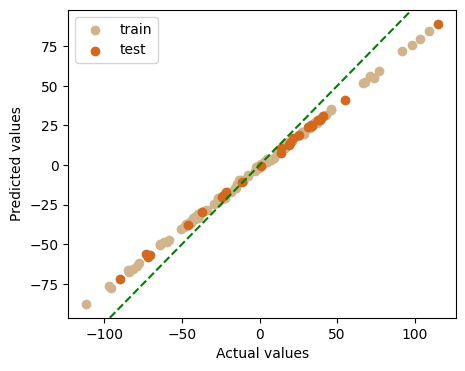

Original dataset shape: (103, 5)
Dataset with polynomial features contains 53130 features


,0
model_name,ElasticNet(random_state=24)
scaler,MinMaxScaler()
polynomial_degree,20
rmse_on_train,28.4833
rmse_on_test,29.8283


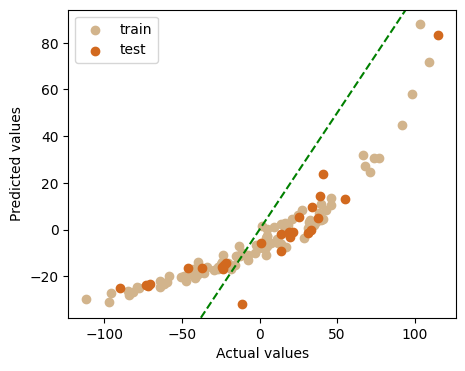

Original dataset shape: (103, 5)
Dataset with polynomial features contains 53130 features


,0
model_name,"ElasticNet(alpha=0.5, random_state=24)"
scaler,MinMaxScaler()
polynomial_degree,20
rmse_on_train,22.2709
rmse_on_test,27.409


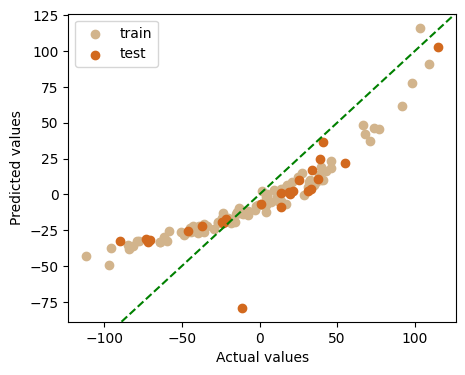

Original dataset shape: (103, 5)
Dataset with polynomial features contains 53130 features


,0
model_name,"ElasticNet(alpha=2, random_state=24)"
scaler,MinMaxScaler()
polynomial_degree,20
rmse_on_train,35.095
rmse_on_test,35.9229


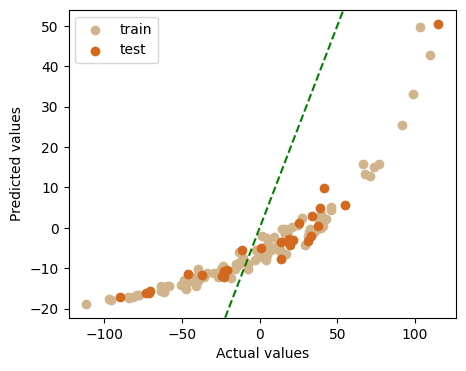

In [19]:
models = [
    LinearRegression(),
    Ridge(random_state=24),
    Ridge(alpha=0.5, random_state=24),
    Ridge(alpha=2, random_state=24),
    Lasso(random_state=24),
    Lasso(alpha=0.5, random_state=24),
    Lasso(alpha=2, random_state=24),
    ElasticNet(random_state=24),
    ElasticNet(alpha=0.5, random_state=24),
    ElasticNet(alpha=2, random_state=24),
]


scaler = MinMaxScaler()
degree = 20

for regressor in models:
    train_and_evaluate_model(scaler, degree, regressor,
                             train_inputs, train_targets,
                             test_inputs, test_targets)


- Lasso model performs better than Ridge and ElasticNet. 
  
  The Lasso model with `alpha = 0.5` provides the best result for `PolynomialFeatures` with `degree = 20`.
- The ElasticNet models give the worst results due to underfitting
- The Ridge models tend to overfit the data


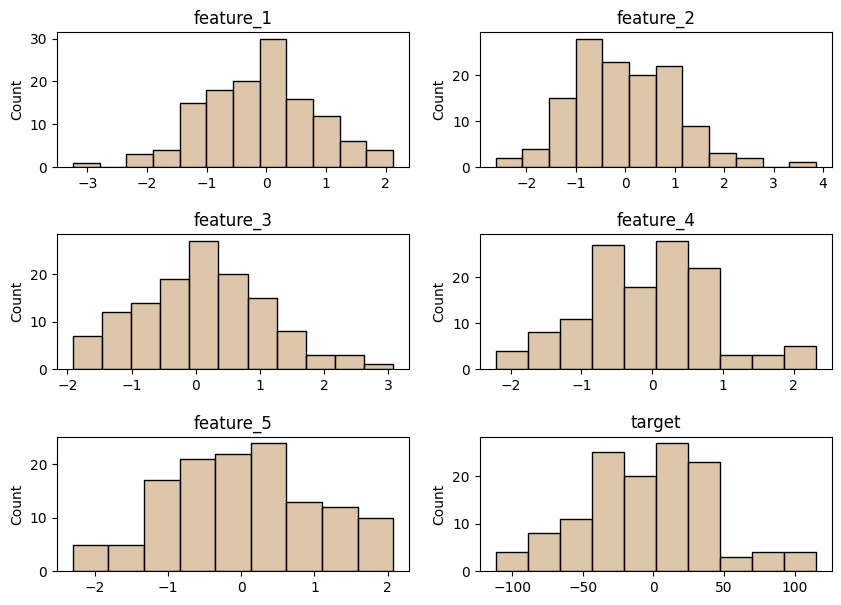

In [20]:
plt.figure(figsize=(10, 7))
plt.subplots_adjust(hspace=0.5)

for n, col in enumerate(regression_data.columns):
    ax = plt.subplot(3, 2, n+1)
    sns.histplot(regression_data[col], ax=ax, color='tan')
    ax.set_title(col)
    ax.set_xlabel('')
plt.show()

In [21]:
regression_data['target'].sort_values().reset_index(drop=True)

0     -111.753810
1      -96.866014
2      -95.969998
3      -89.954844
4      -84.716959
          ...    
124     91.770588
125     98.496591
126    103.211332
127    109.455091
128    115.125907
Name: target, Length: 129, dtype: float64

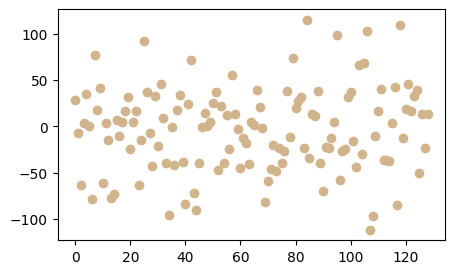

In [26]:
plt.figure(figsize=(5, 3))
plt.plot(regression_data['target'], 'o', color='tan')
plt.show()

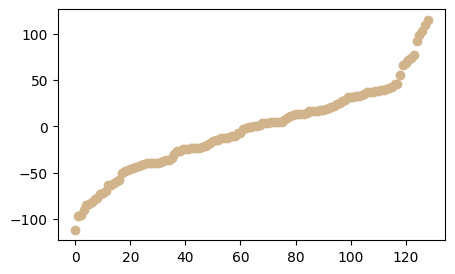

In [27]:
plt.figure(figsize=(5, 3))
plt.plot(regression_data['target'].sort_values().reset_index(drop=True), 'o', color='tan')
plt.show()

Original dataset shape: (103, 5)
Dataset with polynomial features contains 6 features


,0
model_name,LinearRegression()
scaler,passthrough
polynomial_degree,1
rmse_on_train,1.0309
rmse_on_test,1.0531


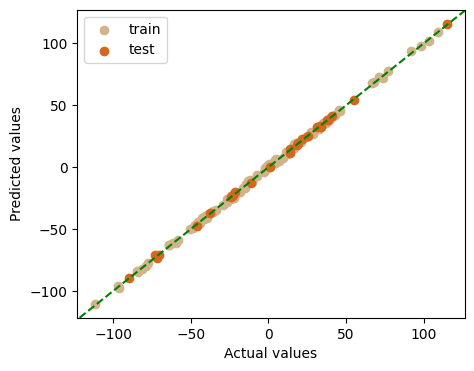

Original dataset shape: (103, 5)
Dataset with polynomial features contains 6 features


,0
model_name,Ridge(random_state=24)
scaler,passthrough
polynomial_degree,1
rmse_on_train,1.1629
rmse_on_test,1.2164


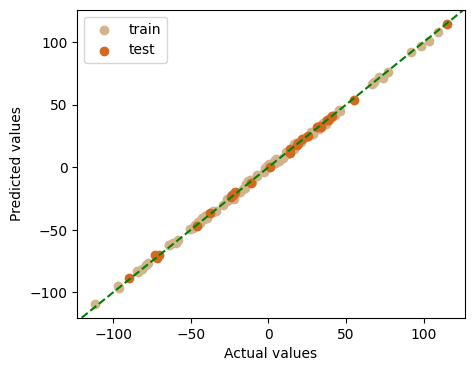

Original dataset shape: (103, 5)
Dataset with polynomial features contains 6 features


,0
model_name,"Ridge(alpha=0.5, random_state=24)"
scaler,passthrough
polynomial_degree,1
rmse_on_train,1.0659
rmse_on_test,1.103


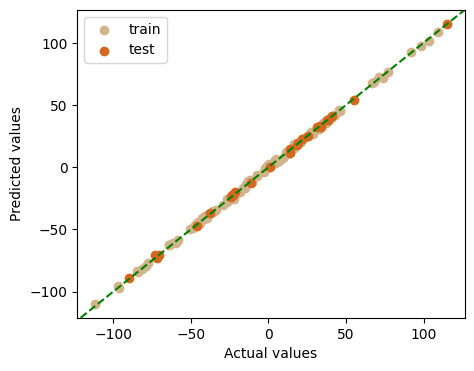

Original dataset shape: (103, 5)
Dataset with polynomial features contains 6 features


,0
model_name,"Ridge(alpha=2, random_state=24)"
scaler,passthrough
polynomial_degree,1
rmse_on_train,1.4809
rmse_on_test,1.565


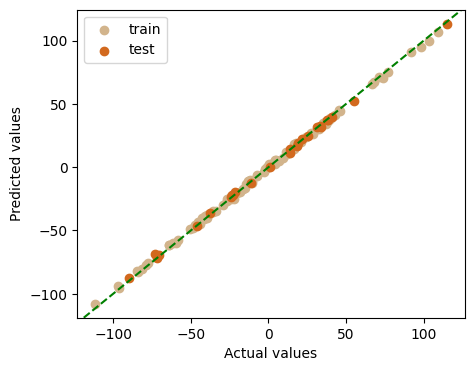

Original dataset shape: (103, 5)
Dataset with polynomial features contains 6 features


,0
model_name,Lasso(random_state=24)
scaler,passthrough
polynomial_degree,1
rmse_on_train,1.5306
rmse_on_test,1.549


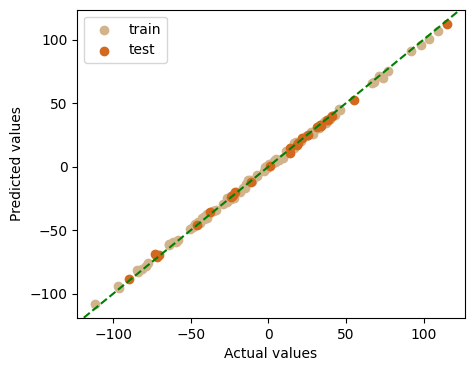

Original dataset shape: (103, 5)
Dataset with polynomial features contains 6 features


,0
model_name,"Lasso(alpha=0.5, random_state=24)"
scaler,passthrough
polynomial_degree,1
rmse_on_train,1.1912
rmse_on_test,1.1735


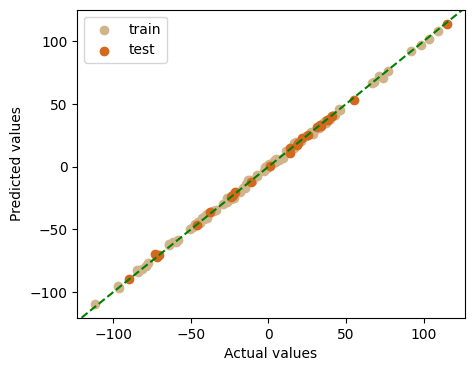

Original dataset shape: (103, 5)
Dataset with polynomial features contains 6 features


,0
model_name,"Lasso(alpha=2, random_state=24)"
scaler,passthrough
polynomial_degree,1
rmse_on_train,2.4571
rmse_on_test,2.5334


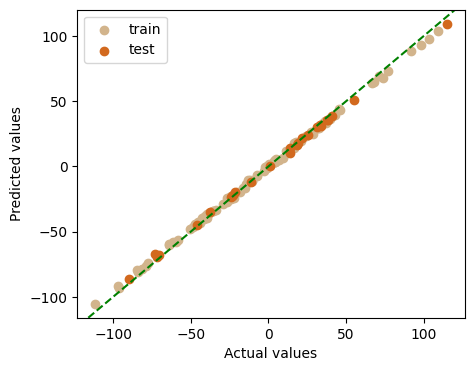

In [24]:
models = [
    LinearRegression(),
    Ridge(random_state=24),
    Ridge(alpha=0.5, random_state=24),
    Ridge(alpha=2, random_state=24),
    Lasso(random_state=24),
    Lasso(alpha=0.5, random_state=24),
    Lasso(alpha=2, random_state=24),
]


scaler = 'passthrough'
degree = 1

for regressor in models:
    train_and_evaluate_model(scaler, degree, regressor,
                             train_inputs, train_targets,
                             test_inputs, test_targets)

Original dataset shape: (103, 5)
Dataset with polynomial features contains 56 features


,0
model_name,LinearRegression()
scaler,passthrough
polynomial_degree,3
rmse_on_train,0.7324
rmse_on_test,3.5923


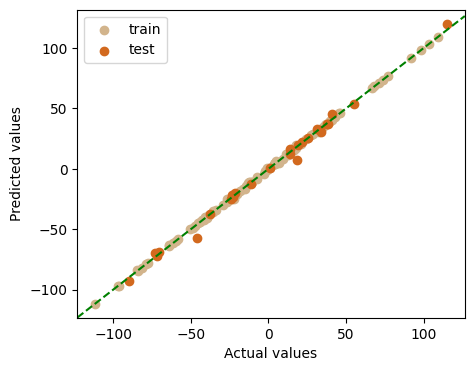

Original dataset shape: (103, 5)
Dataset with polynomial features contains 56 features


,0
model_name,Ridge(random_state=24)
scaler,passthrough
polynomial_degree,3
rmse_on_train,1.8519
rmse_on_test,8.8641


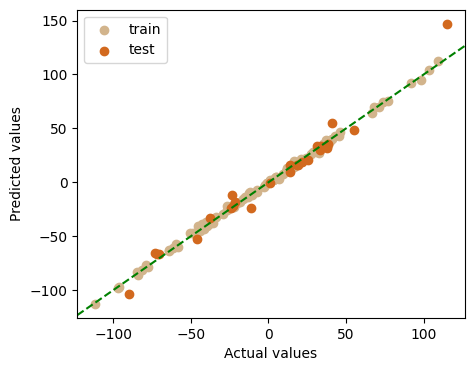

Original dataset shape: (103, 5)
Dataset with polynomial features contains 56 features


,0
model_name,"Ridge(alpha=0.5, random_state=24)"
scaler,passthrough
polynomial_degree,3
rmse_on_train,1.1931
rmse_on_test,6.0146


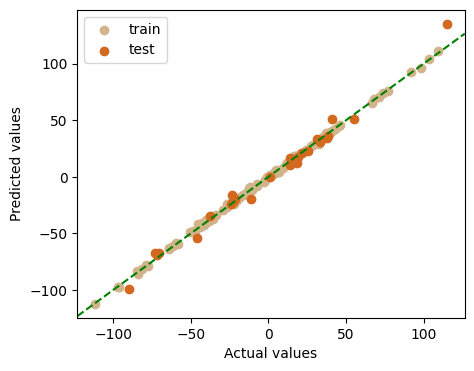

Original dataset shape: (103, 5)
Dataset with polynomial features contains 56 features


,0
model_name,"Ridge(alpha=2, random_state=24)"
scaler,passthrough
polynomial_degree,3
rmse_on_train,2.9554
rmse_on_test,13.1518


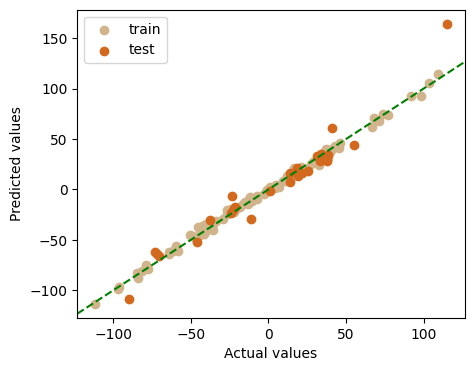

Original dataset shape: (103, 5)
Dataset with polynomial features contains 56 features


,0
model_name,Lasso(random_state=24)
scaler,passthrough
polynomial_degree,3
rmse_on_train,1.8443
rmse_on_test,2.2114


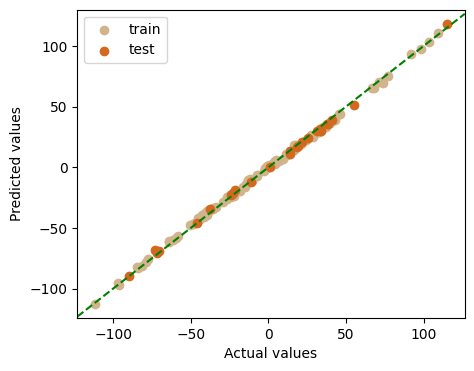

Original dataset shape: (103, 5)
Dataset with polynomial features contains 56 features


,0
model_name,"Lasso(alpha=0.5, random_state=24)"
scaler,passthrough
polynomial_degree,3
rmse_on_train,1.2809
rmse_on_test,1.5674


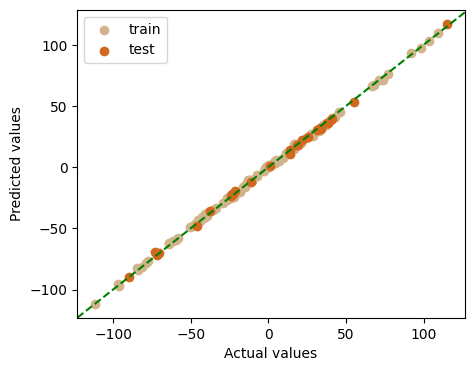

Original dataset shape: (103, 5)
Dataset with polynomial features contains 56 features


,0
model_name,"Lasso(alpha=2, random_state=24)"
scaler,passthrough
polynomial_degree,3
rmse_on_train,3.229
rmse_on_test,3.784


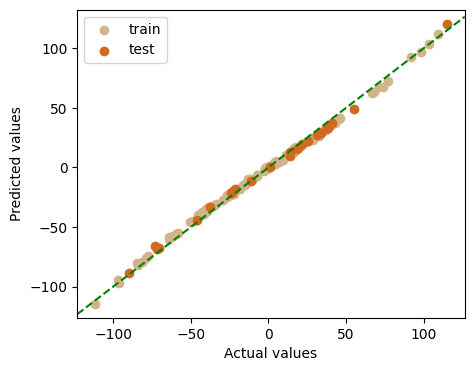

In [ ]:
models = [
    LinearRegression(),
    Ridge(random_state=24),
    Ridge(alpha=0.5, random_state=24),
    Ridge(alpha=2, random_state=24),
    Lasso(random_state=24),
    Lasso(alpha=0.5, random_state=24),
    Lasso(alpha=2, random_state=24),
]


scaler = 'passthrough'
degree = 3

for regressor in models:
    train_and_evaluate_model(scaler, degree, regressor,
                             train_inputs, train_targets,
                             test_inputs, test_targets)

In this dataset, the features are approximately within the same range (-3, 3), while the target variable is in the range (-120, 120). For this reason, we don't need to penalize the model for having lower coefficient values. 
As the result, the best model is simple linear regression without polynomial features. 

RMSE for this model:
- train: 1.0309
- test:	1.0531